In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa

from shapely.geometry import Point, Polygon

from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt

import sys
sys.path.append('../../funcs/')
from xarray_tools import find_cor_ts
from plotting import map_grid_clean

In [2]:
lcc_bounds = gpd.read_file('/Users/rdcrlzh1/Documents/uavsar-coherence/data/example_bounds/snowbird.shp').total_bounds
ex_features = gpd.read_file('/Users/rdcrlzh1/Documents/uavsar-coherence/data/example_bounds/snowbird_southface.shp')

In [3]:
def inches_to_meters(x): return x * 0.0254
def fahrenheit_to_celsius(x): return (x-32) * 5/9
def convert_snotel(df):
    df['SWE'] = df['SWE'].map(inches_to_meters)
    df['SWE_units'] = 'm'
    df['SNOWDEPTH'] = df['SNOWDEPTH'].map(inches_to_meters)
    df['SNOWDEPTH_units'] = 'm'
    df['AVG AIR TEMP'] = df['AVG AIR TEMP'].map(fahrenheit_to_celsius)
    df['AVG AIR TEMP_units']  = 'degC'
    return df

In [4]:
das = {}
for fp in Path('/Users/rdcrlzh1/Desktop/gis').glob('*.tif'):
    da = xr.open_dataarray(fp)
    t1, t2= fp.stem.split('_')
    t1, t2 = [pd.to_datetime(t) for t in [t1, t2]]
    da['band'] = ['VV','VH','HH']
    da = da.rename(band = 'pol')
    das[fp.stem] = da.expand_dims(time1 = [t1], time2 = [t2])

In [5]:
snotel_geoms = {}
snotels = {}
for fp in Path('/Users/rdcrlzh1/Documents/uavsar-coherence/data/snotel/stlake').glob('*.csv'):
    if fp.stem == '814:UT:SNTL': continue
    df = pd.read_csv(fp, parse_dates=True, index_col=0)
    df = convert_snotel(df)
    snotels[fp.stem] = df

    x, y, z = df['geometry'].iloc[0].replace('(', '').replace(')', '').split(' ')[2:]
    snotel_geoms[fp.stem] = Point(x, y, z)

In [6]:
def merge_subplots(axes, fig, gs, start_row, end_row):
    for ax in axes[start_row:end_row, :].ravel(): ax.remove()
    ax = fig.add_subplot(gs[start_row:end_row, :])
    return ax


def add_interval(ax, xdata, ydata, caps="  ", color = 'grey'):
    """
    https://stackoverflow.com/questions/52743119/line-end-styles-in-matplotlib
    """
    line = ax.add_line(mpl.lines.Line2D(xdata, ydata, color = color))
    anno_args = {
        'ha': 'center',
        'va': 'center',
        'size': 14,
        'color': line.get_color()
    }
    a0 = ax.annotate(caps[0], xy=(xdata[0], ydata[0]), **anno_args)
    a1 = ax.annotate(caps[1], xy=(xdata[1], ydata[1]), **anno_args)
    return (line,(a0,a1))

def add_uavsar_to_snotel_conn(da, y_value, ax1, ax2, color = 'black', ax3 = None, ax3_df = None):
    xy1 = [pd.to_datetime(da.time1.values.ravel()[0]), y_value]
    xy2 = [lcc_bounds[0], lcc_bounds[3]]
    con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                        axesA=ax1, axesB=ax2, color=color)
    ax2.add_artist(con)
    xy1 = [pd.to_datetime(da.time2.values.ravel()[0]), y_value]
    xy2 = [lcc_bounds[2], lcc_bounds[3]]
    con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                        axesA=ax1, axesB=ax2, color=color)
    ax2.add_artist(con)

    add_interval(ax1, [da.time1.values.ravel()[0], da.time2.values.ravel()[0]], [-10, -10], caps = "()", color = color)
    t1, t2= da.time1.values.ravel()[0], da.time2.values.ravel()[0]
    t1, t2 = [pd.to_datetime(t).tz_localize('UTC') for t in [t1, t2]]
    y1, y2 = snotels['766:UT:SNTL'][t1:t2]['SNOWDEPTH'].iloc[0], snotels['766:UT:SNTL']['SNOWDEPTH'][t1:t2].iloc[-1]
    add_interval(ax3, [da.time1.values.ravel()[0], da.time2.values.ravel()[0]], [y1, y2], caps = "()", color = color)

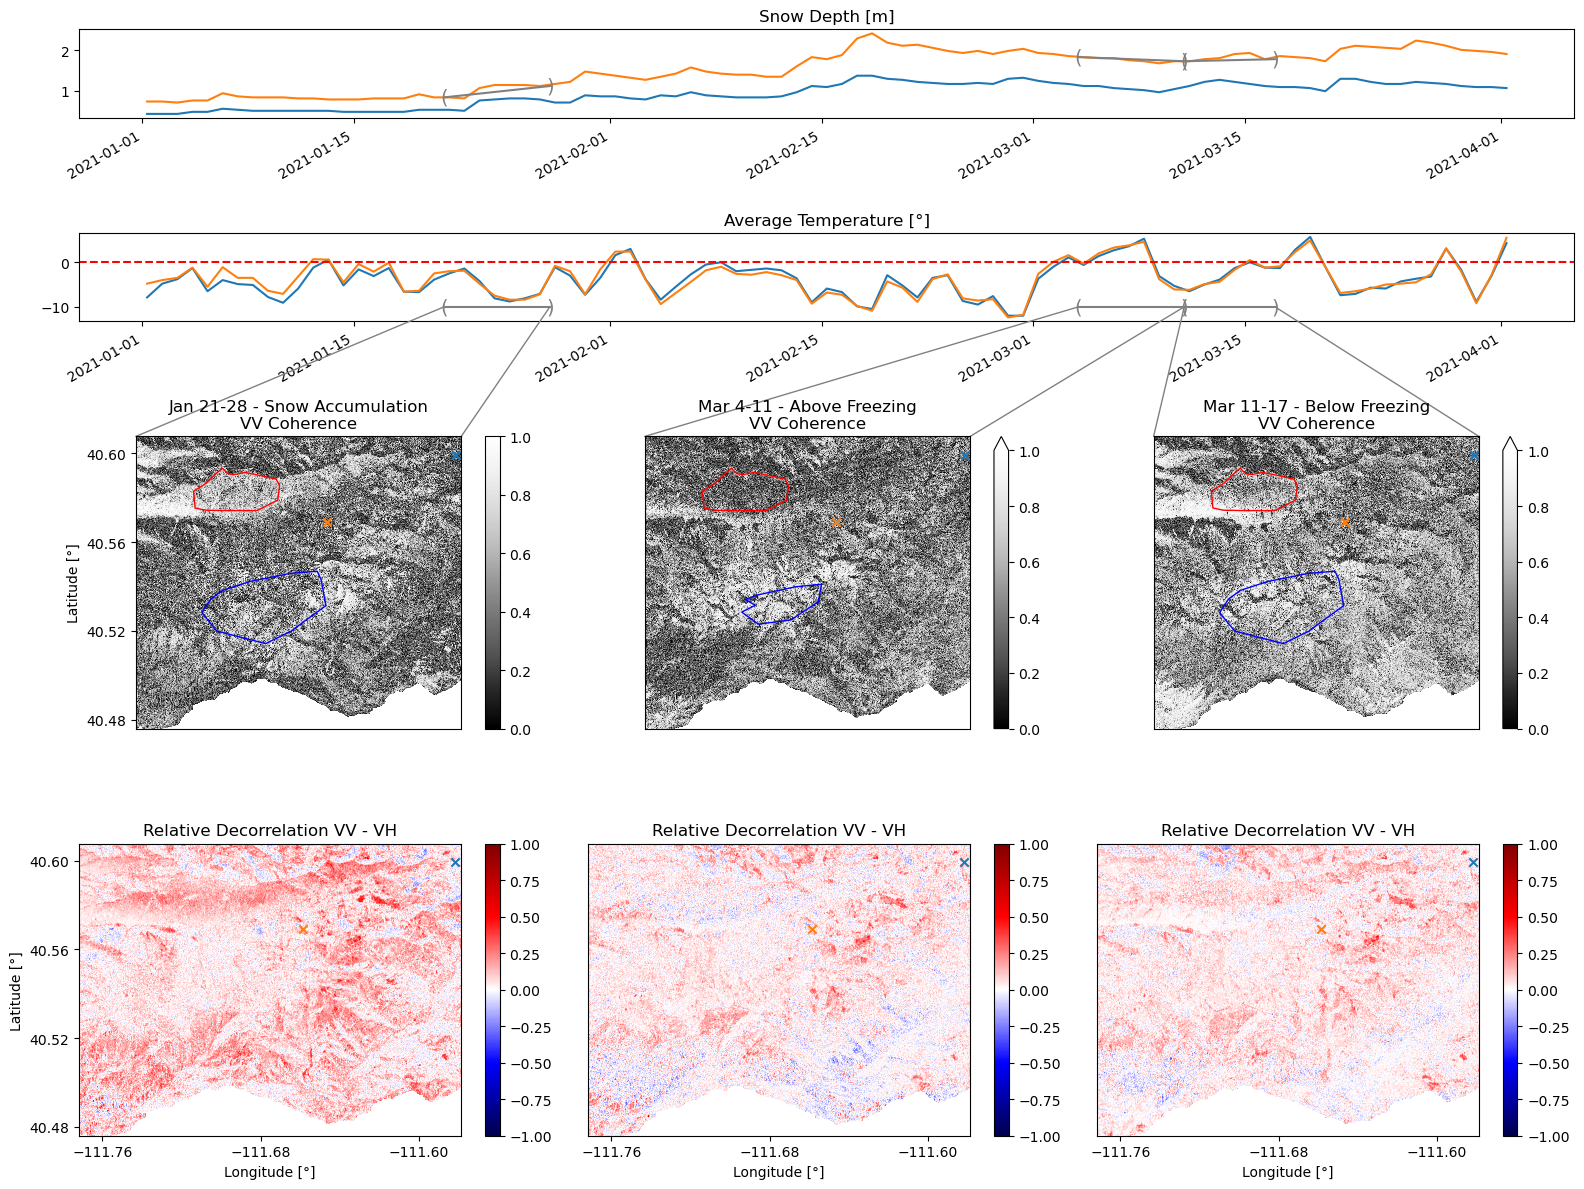

In [8]:
from matplotlib.patches import ConnectionPatch

cm = 'Greys_r'
cm2 = 'seismic'

debug = False

snotel_height = 1
uavsar_height = 2
cols = 9
rows = snotel_height*2 + uavsar_height*2
assert snotel_height*2 + uavsar_height*2 == rows
fig, axes = plt.subplots(rows, cols, figsize = (16, 12))

# make first two rows of subplots wide
gs = axes[0, 0].get_gridspec()
# merge wide for snotel subplots
ax1 = merge_subplots(axes, fig, gs, 0, snotel_height)
ax2 = merge_subplots(axes, fig, gs, snotel_height, 2*snotel_height)
# merge every other

uaxes = []
for i in range(3):
    start, end = 2*snotel_height, 2*snotel_height+uavsar_height
    for ax in axes[start:end, int(i*cols/3):int((i+1)*cols/3)].ravel(): ax.remove()
    ax3 = fig.add_subplot(gs[start:end, int(i*cols/3):int((i+1)*cols/3)])

    start, end = 2*snotel_height+uavsar_height, cols
    for ax in axes[start:end,int(i*cols/3):int((i+1)*cols/3)].ravel(): ax.remove()
    ax4 = fig.add_subplot(gs[2*snotel_height+uavsar_height:, int(i*cols/3):int((i+1)*cols/3)])

    uaxes.extend([ax3, ax4])

#### plot snotels ####
for name, snotel in snotels.items():
    # print(name)
    snotel['2021-01-01':'2021-04-01']['SNOWDEPTH'].plot(ax = ax1)
    snotel['2021-01-01':'2021-04-01']['AVG AIR TEMP'].plot(ax = ax2)
ax1.set_title('Snow Depth [m]')
ax2.set_title('Average Temperature [°]')
ax2.axhline(0, color = 'red', linestyle = 'dashed')

#### plot uavsar coherences ####
# cold period with snow
da = das['2021-01-21_2021-01-28']
if not debug:
    da.sel(pol = 'VV').plot(ax = uaxes[0], vmax = 1, vmin = 0, cmap = cm, cbar_kwargs = {'label':''})
    # rgb image
    # da.isel(time1 = 0, time2 = 0).transpose('y','x','pol').plot.imshow(ax = uaxes[1], vmax = 1, vmin = 0)
    ((da.sel(pol = 'VV') - da.sel(pol = 'VH')) / (da.sel(pol = 'VH') + da.sel(pol = 'VV'))).rolling(x = 10, y = 10).mean().plot( ax = uaxes[1], vmax = 1, vmin = -1, cmap = cm2, cbar_kwargs = {'label':''})
main_title = 'VV Coherence'
uaxes[0].set_title(f'Jan 21-28 - Snow Accumulation\n{main_title}')

# warm period with little snow
da = das['2021-03-04_2021-03-11']
if not debug:
    da.sel(pol = 'VV').plot(ax = uaxes[2], vmax = 1, vmin = 0, cmap = cm, cbar_kwargs = {'label':''})
    # da.isel(time1 = 0, time2 = 0).transpose('y','x','pol').plot.imshow(ax = uaxes[3], vmax = 1, vmin = 0)
    ((da.sel(pol = 'VV') - da.sel(pol = 'VH')) / (da.sel(pol = 'VH') + da.sel(pol = 'VV'))).rolling(x = 10, y = 10).mean().plot( ax = uaxes[3], vmax = 1, vmin = -1, cmap = cm2, cbar_kwargs = {'label':''})
uaxes[2].set_title(f'Mar 4-11 - Above Freezing\n{main_title}')

# cold period with little snow
da = das['2021-03-11_2021-03-17']
if not debug:
    da.sel(pol = 'VV').plot(ax = uaxes[4], vmax = 1, vmin = 0, cmap = cm, cbar_kwargs = {'label':''})
    # da.isel(time1 = 0, time2 = 0).transpose('y','x','pol').plot.imshow(ax = uaxes[5], vmax = 1, vmin = 0)
    ((da.sel(pol = 'VV') - da.sel(pol = 'VH')) / (da.sel(pol = 'VH') + da.sel(pol = 'VV'))).rolling(x = 10, y = 10).mean().plot( ax = uaxes[5], vmax = 1, vmin = -1, cmap = cm2, cbar_kwargs = {'label':''})
uaxes[4].set_title(f'Mar 11-17 - Below Freezing\n{main_title}')


for uax in uaxes:
    for g in snotel_geoms.values(): uax.scatter(g.x, g.y, marker = 'x')
    # uax.set_xlim(left = -111.67, right = -111.53)
    # uax.set_ylim(top = 40.625, bottom = 40.565)
    uax.set_xlim(left = lcc_bounds[0], right = lcc_bounds[2])
    uax.set_ylim(bottom = lcc_bounds[1], top = lcc_bounds[3])

for sax in [ax1, ax2]:
    sax.set_xlabel('')

map_grid_clean(np.array(uaxes))
for ax in np.array(uaxes)[::2]: ax.set_xlabel(''); ax.set_xticks([])
for ax in np.array(uaxes)[1::2]: ax.set_xlabel('Longitude [°]');ax.set_title('Relative Decorrelation VV - VH') #ax.set_title('VV Coherence = Red, VH = Green, HH = Blue')
uaxes[1].set_ylabel('Latitude [°]'); uaxes[1].yaxis.set_major_locator(plt.MaxNLocator(4))

plt.tight_layout()

da = das['2021-01-21_2021-01-28']
add_uavsar_to_snotel_conn(da, -10, ax2, uaxes[0], 'grey', ax1, snotels['766:UT:SNTL'])

da = das['2021-03-04_2021-03-11']
add_uavsar_to_snotel_conn(da, -10, ax2, uaxes[2], 'grey', ax1, snotels['766:UT:SNTL'])

da = das['2021-03-11_2021-03-17']
add_uavsar_to_snotel_conn(da, -10, ax2, uaxes[4], 'grey', ax1, snotels['766:UT:SNTL'])

ex_features[ex_features.id == 1].plot(facecolor="None", edgecolor = 'red', ax = uaxes[0])
ex_features[ex_features.id == 1].plot(facecolor="None", edgecolor = 'red', ax = uaxes[2])
ex_features[ex_features.id == 1].plot(facecolor="None", edgecolor = 'red', ax = uaxes[4])

ex_features[ex_features.id == 2].plot(facecolor="None", edgecolor = 'blue', ax = uaxes[0])
ex_features[ex_features.id == 2].plot(facecolor="None", edgecolor = 'blue', ax = uaxes[4])
ex_features[ex_features.id == 3].plot(facecolor="None", edgecolor = 'blue', ax = uaxes[2])

fig_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence/figures/examples')
plt.savefig(fig_dir.joinpath('stlake-2021.png'))